# DiffCYT workflow

The purpose of this workflow is to produce SNE graphs from FlowJo flow files.

## Flow File location
Change the path below to the location of the flow files on galaxy.

In [1]:
setwd("/home/mproffitt/flows/9colourFlow2019")

## Parameters

In [2]:
lineage_markers <- c()
functional_markers <- c()

cluster_xdim <- 10
cluster_ydim <- 10
cluster_maxK <- 20
cluster_seed <- 1

tsne_iterations <- 500
tsne_seed <- 42
tsne_target_cols <- c("Dll4", "Jag1") # if empty, all columns will be targetted

## Includes
Include the following packages

In [3]:
suppressPackageStartupMessages({
    library(CATALYST)
    library(flowCore)
    library(diffcyt)
    library(SummarizedExperiment)
})

## Load files

In [4]:
fcs_files <- list.files(pattern = ".fcs$")
fcs_files

[1] "Gfi1 Tom E10 E1025 and E105 070119_Gfi1 tom 2ee 070119 2728s 1.fcs"
[2] "Gfi1 Tom E10 E1025 and E105 070119_Gfi1 tom 2ee 070119 2728s 2.fcs"
[3] "Gfi1 Tom E10 E1025 and E105 070119_Gfi1 tom 2ee 070119 2728s 3.fcs"
[4] "Gfi1 Tom E10 E1025 and E105 070119_Gfi1 tom 2ee 070119 3536s 1.fcs"
[5] "Gfi1 Tom E10 E1025 and E105 070119_Gfi1 tom 2ee 070119 3536s 2.fcs"
[6] "Gfi1 Tom E10 E1025 and E105 070119_Gfi1 tom 2ee 070119 3536s 3.fcs"

## Create flowset
Create a flowset from the loaded file set

In [5]:
fs <- read.flowSet(fcs_files, transformation = FALSE, truncate_max_range = FALSE)

## Create the MetaData
The metadata consists of information normally extracted from the filenames which depict the experiment.

It would normally be necessary to re-work this block to define metadata based on the experiment.

In [6]:
file <- as.character(pData(fs)$name)
sample_id <- 1:length(fs)

sample <- gsub(
    "[0-9]+s", "",
    gsub(
        "^Gfi1 Tom E10 E1025 and E105 070119_Gfi1 tom 2ee 070119 ", "",
        gsub("\\.fcs$", "", file)
    )
)

group_id <- gsub(
    "^Gfi1 Tom E10 E1025 and E105 070119_Gfi1 tom 2ee 070119 ", "",
    gsub("[0-9]+\\.fcs$", "", file)
)

experiment_info <- data.frame(
  sample_id, file, group_id, sample, stringsAsFactors = FALSE
)
experiment_info

sample_id,file,group_id,sample
1,Gfi1 Tom E10 E1025 and E105 070119_Gfi1 tom 2ee 070119 2728s 1.fcs,2728s,1
2,Gfi1 Tom E10 E1025 and E105 070119_Gfi1 tom 2ee 070119 2728s 2.fcs,2728s,2
3,Gfi1 Tom E10 E1025 and E105 070119_Gfi1 tom 2ee 070119 2728s 3.fcs,2728s,3
4,Gfi1 Tom E10 E1025 and E105 070119_Gfi1 tom 2ee 070119 3536s 1.fcs,3536s,1
5,Gfi1 Tom E10 E1025 and E105 070119_Gfi1 tom 2ee 070119 3536s 2.fcs,3536s,2
6,Gfi1 Tom E10 E1025 and E105 070119_Gfi1 tom 2ee 070119 3536s 3.fcs,3536s,3


In [7]:
panel <- guessPanel(fs, index = 1)
panel

fcs_colname,desc,antigen,use_channel
FSC-A,NA,NA,1
FSC-H,NA,NA,1
FSC-W,NA,NA,1
SSC-A,NA,NA,1
SSC-H,NA,NA,1
SSC-W,NA,NA,1
FITC-A,Jag1,Jag1,1
PerCP-Cy5-5-A,Dll4,Dll4,1
Pacific Blue-A,Notch1,Notch1,1
Qdot 605-A,CD31,CD31,1


## Create the panel from the flowset
Attempts to guess the panel (a 2 column data.frame that contains for each marker of interest i) its column name in the raw input data, and ii) its targeted protein marker).

In [8]:
marker_name <- markernames(fs)
channel_name <- as.vector(panel[(panel$desc %in% marker_name),]$fcs_colname)

marker_class <- rep("none", length(channel_name))
marker_class <- factor(marker_class, levels = c("type", "state", "none"))

marker_info <- data.frame(
  channel_name, marker_name, marker_class, stringsAsFactors = FALSE
)

marker_info$marker_class[marker_info$marker_name %in% lineage_markers] <- "type"
marker_info$marker_class[marker_info$marker_name %in% functional_markers] <- "state"
marker_info

channel_name,marker_name,marker_class
FITC-A,Jag1,none
PerCP-Cy5-5-A,Dll4,none
Pacific Blue-A,Notch1,none
Qdot 605-A,CD31,none
APC-A,Notch3,none
Alexa Fluor 700-A,Notch2,none
APC-Cy7-A,cKIT,none
PE-A,Gfi1,none
PE-Cy7-A,CD45,none


In [17]:
daf <- daFrame(
    fs,
    marker_info,
    experiment_info,
    panel_cols=list(channel="channel_name", antigen="marker_name", class="marker_class"),
    md_cols=list(file="file", id="sample_id", factors=c("group_id", "sample"))
)

clustered <- cluster(daf, cols_to_use = tsne_target_cols,#marker_info$marker_name,
    xdim = cluster_xdim, ydim = cluster_ydim, maxK = cluster_maxK,
    verbose = FALSE, seed = cluster_seed
)

clustered

class: daFrame 
dim: 268397 9 
metadata(6): experiment_info n_cells ... cluster_codes delta_area
assays(1): exprs
rownames: NULL
rowData names(4): sample_id group_id sample cluster_id
colnames(9): Jag1 Dll4 ... Gfi1 CD45
colData names(3): channel_name marker_name marker_class

## Cluster and Convert to tSNE 

In [18]:
if(length(tsne_target_cols) == 0) {
    tsne_target_cols <- c(marker_info$marker_name)
}
tsne <- tSNE(clustered, cols_to_use = c(tsne_target_cols),
    n = tsne_iterations, verbose = FALSE, seed = tsne_seed)

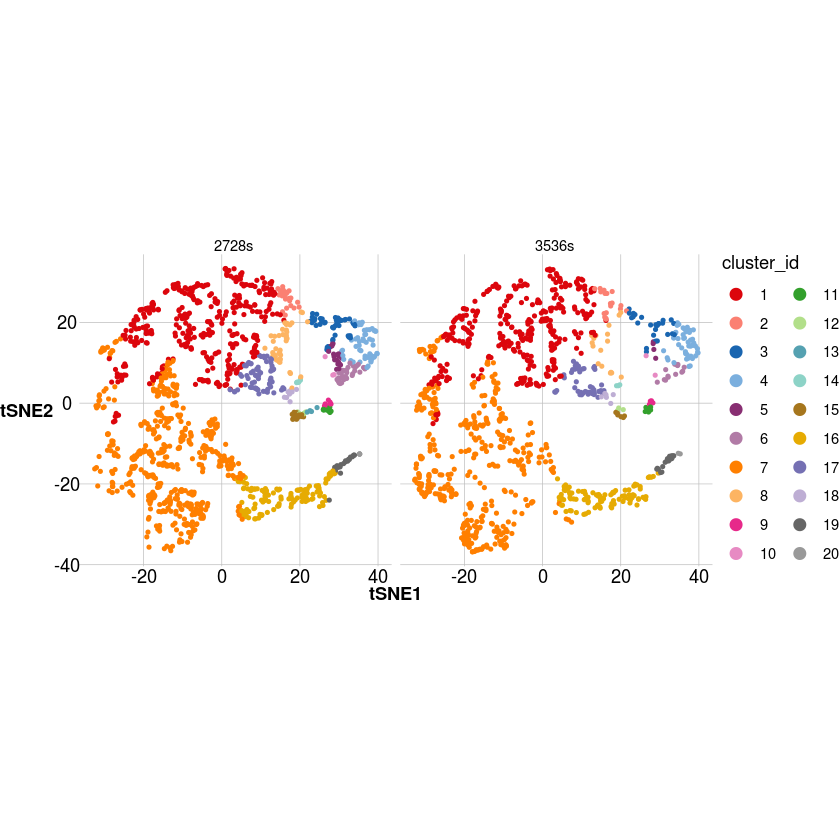

In [20]:
plotSNE(tsne, facet = "group_id", color="meta20")#sprintf("meta%d", length(tsne_target_cols)))

$experiment_info
  sample_id                                                               file
1         1 Gfi1 Tom E10 E1025 and E105 070119_Gfi1 tom 2ee 070119 2728s 1.fcs
2         2 Gfi1 Tom E10 E1025 and E105 070119_Gfi1 tom 2ee 070119 2728s 2.fcs
3         3 Gfi1 Tom E10 E1025 and E105 070119_Gfi1 tom 2ee 070119 2728s 3.fcs
4         4 Gfi1 Tom E10 E1025 and E105 070119_Gfi1 tom 2ee 070119 3536s 1.fcs
5         5 Gfi1 Tom E10 E1025 and E105 070119_Gfi1 tom 2ee 070119 3536s 2.fcs
6         6 Gfi1 Tom E10 E1025 and E105 070119_Gfi1 tom 2ee 070119 3536s 3.fcs
  group_id sample
1   2728s       1
2   2728s       2
3   2728s       3
4   3536s       1
5   3536s       2
6   3536s       3

$n_cells
    1     2     3     4     5     6 
22896 38973 29695 58066 59942 58825 

$cofactor
[1] 5

$SOM_codes
             Jag1         Dll4     Notch1      CD31      Notch3    Notch2
  [1,]  3.6096602  3.502904327  4.0437856 -3.588850  2.52184269 -3.068323
  [2,]  2.4916330  3.073104586  2.3783812 -

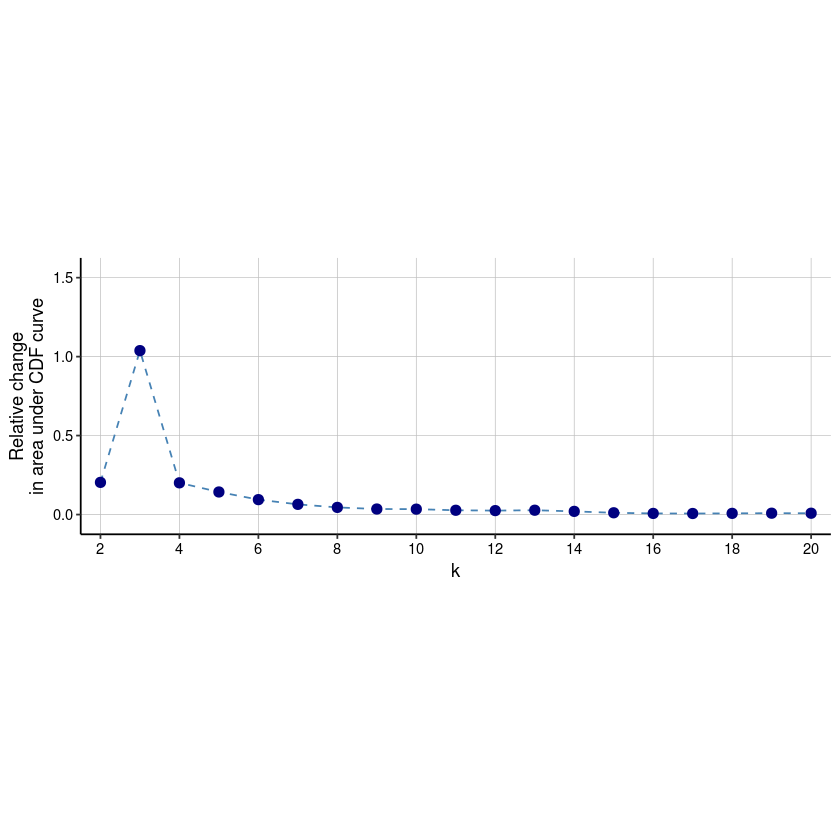

In [12]:
metadata(clustered)